# Data Matching

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

C:\Users\user\miniconda3\envs\jcopml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('data/TA FIX.csv', index_col='ID')
df.head()

,Generator,Status,Result Status,Proxy Role,Keep SR3,Has SR3,Rating,BHP,Depth,OilVisc,Perm,Por,RF,Execution Node,Dataset Path,Optimal,MCMC Count,Comment
ID,,,,,,,,,,,,,,,,,,
0,Reuse,Reused,NormalTermination,Ignore,Yes,1.0,0,350.0,4910.0,0.441151,30.0,0.20,25.059633,NaN,ORIGINAL.dat,NaN,0,NaN
1,LatinHyperCube,Complete,NormalTermination,Training,Auto,NaN,0,297.5,3682.5,0.441151,36.0,0.15,27.093252,PETROLEUMCOMPUT,BaseCase Coding.cmsd\BaseCase Coding_00011.dat,NaN,0,NaN
2,LatinHyperCube,Complete,NormalTermination,Training,Auto,NaN,0,402.5,4419.0,0.441151,25.5,0.23,23.787636,PETROLEUMCOMPUT,BaseCase Coding.cmsd\BaseCase Coding_00012.dat,NaN,0,NaN
3,LatinHyperCube,Complete,NormalTermination,Training,Auto,NaN,0,437.5,5401.0,0.463209,36.0,0.25,22.222971,PETROLEUMCOMPUT,BaseCase Coding.cmsd\BaseCase Coding_00017.dat,NaN,0,NaN
4,LatinHyperCube,Complete,NormalTermination,Training,Auto,NaN,0,350.0,5646.5,0.463209,27.0,0.20,25.073727,PETROLEUMCOMPUT,BaseCase Coding.cmsd\BaseCase Coding_00028.dat,NaN,0,NaN


In [3]:
df.columns

Index(['Generator', 'Status', 'Result Status', 'Proxy Role', 'Keep SR3',
       'Has SR3', 'Rating', 'BHP', 'Depth', 'OilVisc', 'Perm', 'Por', 'RF',
       'Execution Node', 'Dataset Path', 'Optimal', 'MCMC Count', 'Comment'],
      dtype='object')

In [4]:
df.drop(columns = (['Generator', 'Status', 'Result Status', 'Proxy Role', 'Keep SR3',
       'Has SR3', 'Rating', 'Execution Node', 'Dataset Path', 'Optimal', 'MCMC Count', 'Comment']), inplace=True)

In [5]:
df.tail(10)

,BHP,Depth,OilVisc,Perm,Por,RF
ID,,,,,,
490,280.17677,6013.5101,0.451177,36.439394,0.15000,27.597382
491,274.87374,6063.1061,0.460089,36.136364,0.15000,27.613441
492,264.26768,6112.7020,0.448949,36.136364,0.15000,27.646772
493,276.64141,6112.7020,0.453405,37.045455,0.15000,27.641874
494,266.03535,6112.7020,0.462317,35.530303,0.15000,27.628090
495,269.57071,6137.5000,0.437809,36.893939,0.15101,27.616253
496,262.50000,6137.5000,0.457861,37.045455,0.15000,27.676735
497,271.33838,6137.5000,0.437809,35.833333,0.15000,27.629889
498,290.78283,6038.3081,0.453405,36.893939,0.15000,27.591558


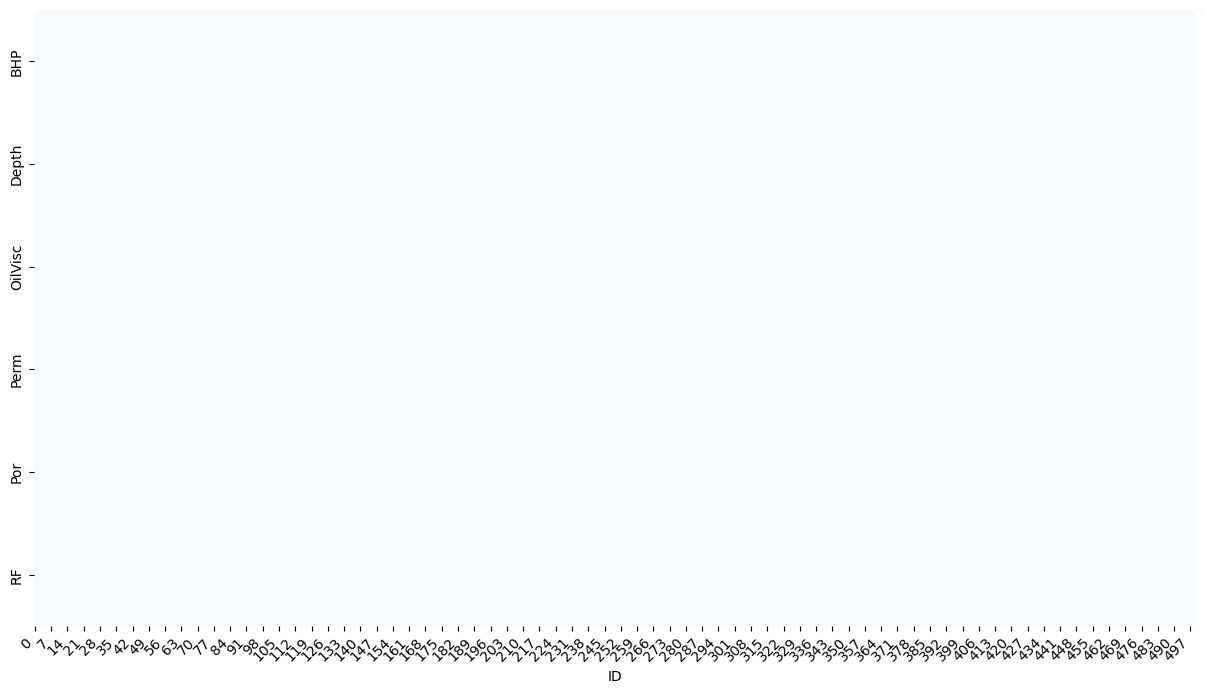

In [6]:
plot_missing_value(df)

<AxesSubplot:>

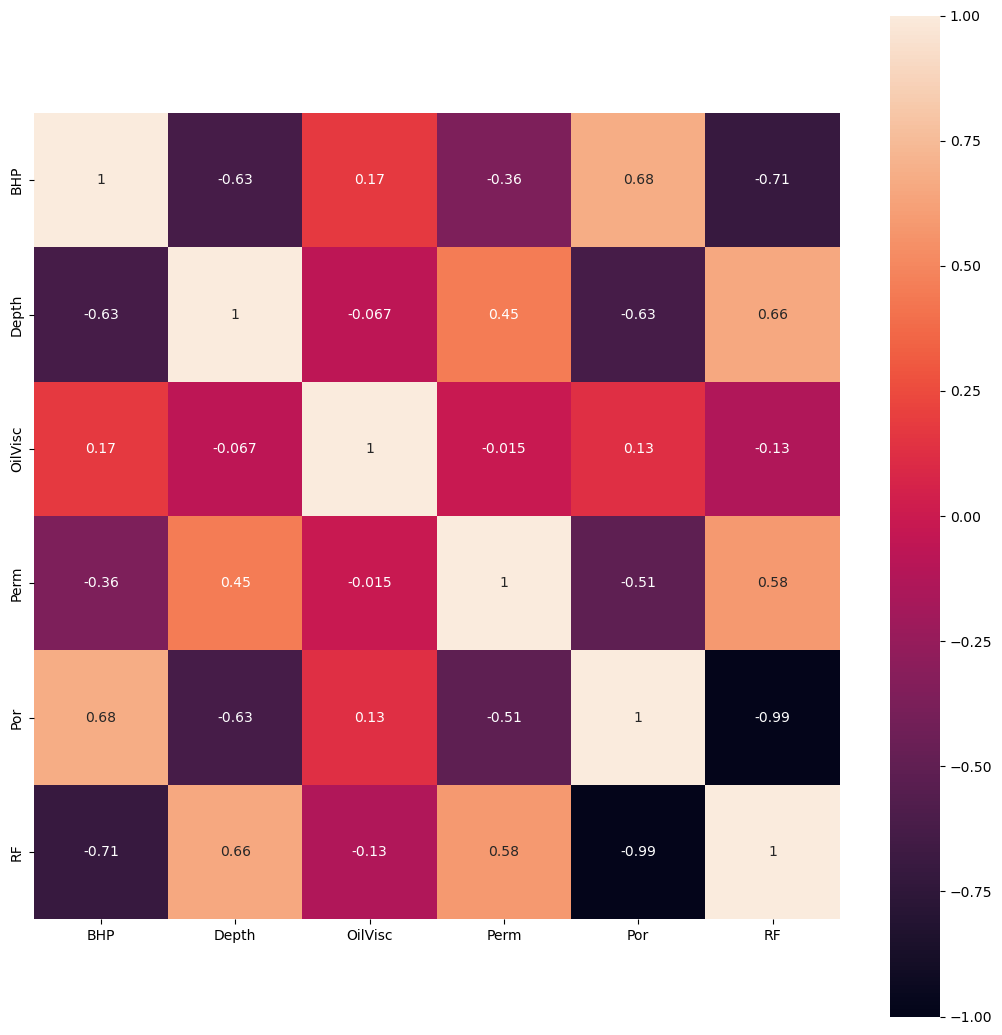

In [7]:
plt.figure(figsize=(13, 13))
sns.heatmap(df.corr(), cbar='False', vmin=-1, vmax=1, annot=True, square=True)

array([[<AxesSubplot:title={'center':'BHP'}>,
        <AxesSubplot:title={'center':'Depth'}>],
       [<AxesSubplot:title={'center':'OilVisc'}>,
        <AxesSubplot:title={'center':'Perm'}>],
       [<AxesSubplot:title={'center':'Por'}>,
        <AxesSubplot:title={'center':'RF'}>]], dtype=object)

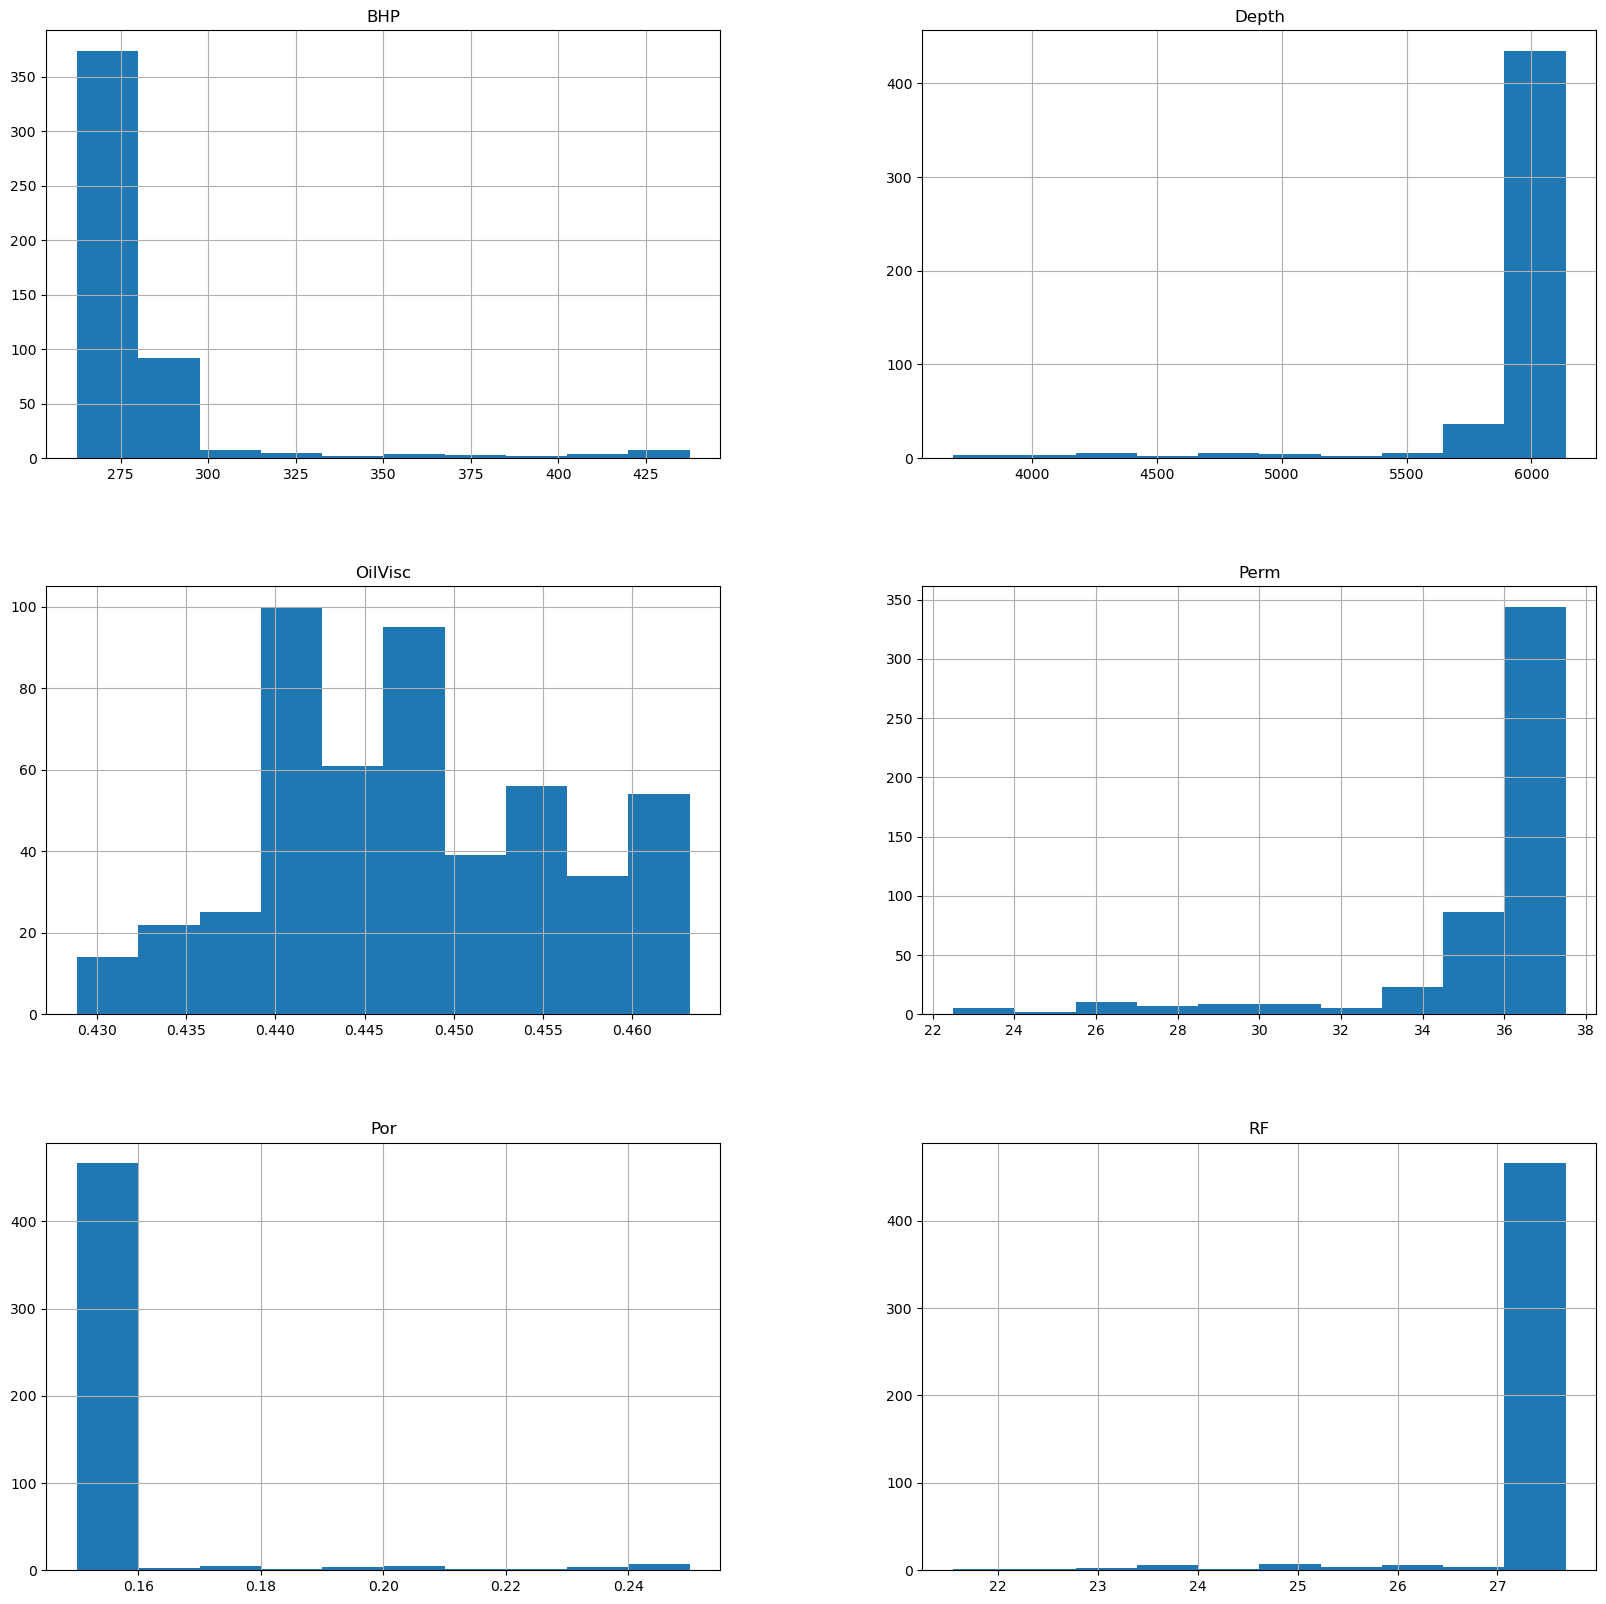

In [8]:
df.hist(figsize=(20, 20))

In [9]:
X = df.drop(columns='RF')
y = df.RF

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 5), (100, 5), (400,), (100,))

In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [11]:
X_train.columns

Index(['BHP', 'Depth', 'OilVisc', 'Perm', 'Por'], dtype='object')

In [12]:
rsp.xgb_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [13]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['BHP', 'Depth', 'OilVisc', 'Perm', 'Por']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model_XGRF = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_XGRF.fit(X_train, y_train)

print(model_XGRF.best_params_)
print(model_XGRF.score(X_train, y_train), model_XGRF.best_score_, model_XGRF.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.6179267600882911, 'algo__gamma': 2, 'algo__learning_rate': 0.14019550306309433, 'algo__max_depth': 1, 'algo__n_estimators': 132, 'algo__reg_alpha': 1.7571818426047676, 'algo__reg_lambda': 1.9167165948710119, 'algo__subsample': 0.6129698350507864, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.9620618307208543 0.9417290502501836 0.9705408598909917


In [14]:
model_XGRF.score(X_train, y_train), model_XGRF.score(X_test, y_test)

(0.9620618307208543, 0.9705408598909917)

In [15]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

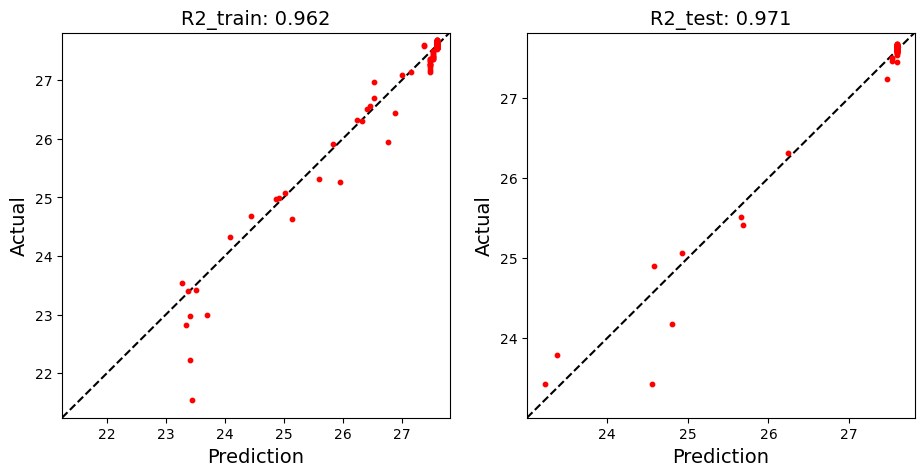

In [16]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_XGRF)

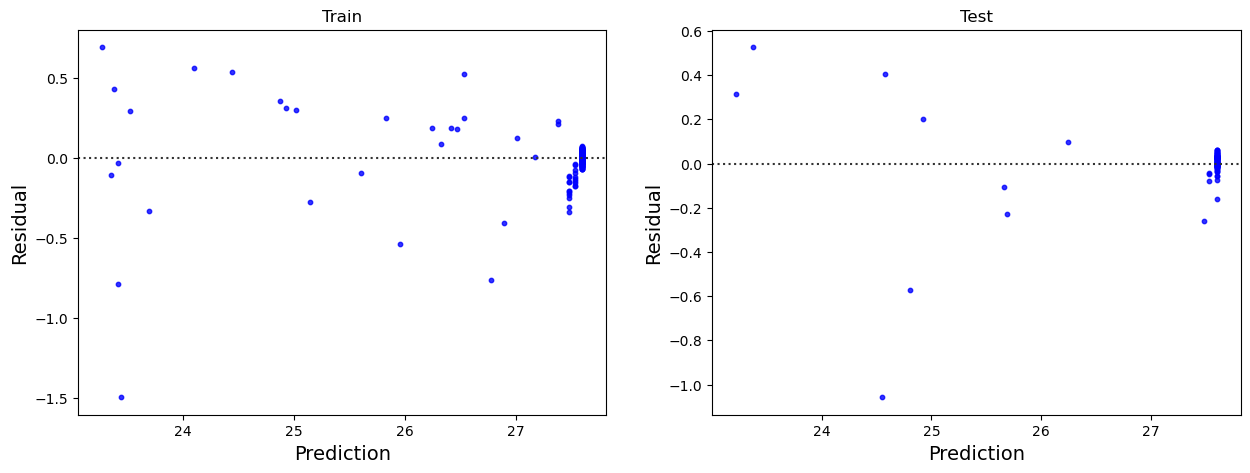

In [17]:
plot_residual(X_train, y_train, X_test, y_test, model_XGRF)

In [18]:
from jcopml.feature_importance import mean_loss_decrease
from jcopml.feature_importance import mean_score_decrease

In [19]:
X_train.iloc[:1]

,BHP,Depth,OilVisc,Perm,Por
ID,,,,,
249,280.17677,6137.5,0.435581,37.5,0.15101


In [20]:
df.head()

,BHP,Depth,OilVisc,Perm,Por,RF
ID,,,,,,
0,350.0,4910.0,0.441151,30.0,0.20,25.059633
1,297.5,3682.5,0.441151,36.0,0.15,27.093252
2,402.5,4419.0,0.441151,25.5,0.23,23.787636
3,437.5,5401.0,0.463209,36.0,0.25,22.222971
4,350.0,5646.5,0.463209,27.0,0.20,25.073727


In [21]:
X_pred=pd.DataFrame([[350.000, 4910.000, 0.4411510, 30.00, 0.2000]], columns=X_train.columns)
X_pred

,BHP,Depth,OilVisc,Perm,Por
0,350.0,4910.0,0.441151,30.0,0.2


In [22]:
model_XGRF.predict(X_pred)

array([24.92352], dtype=float32)

C:\Users\user\miniconda3\envs\jcopml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


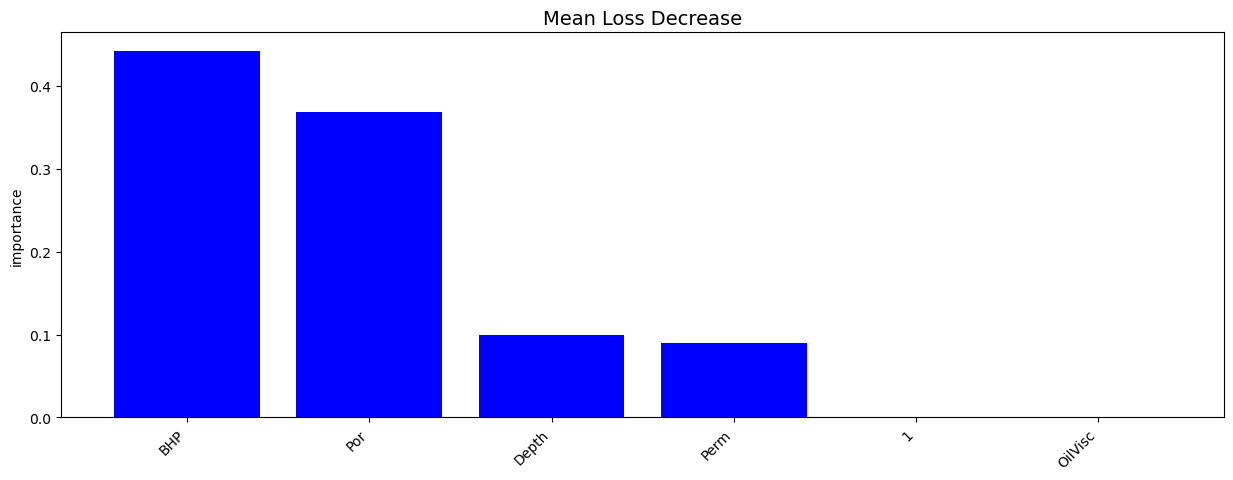

In [23]:
df_imp = mean_loss_decrease(X_train, model_XGRF, plot=True, topk=10)

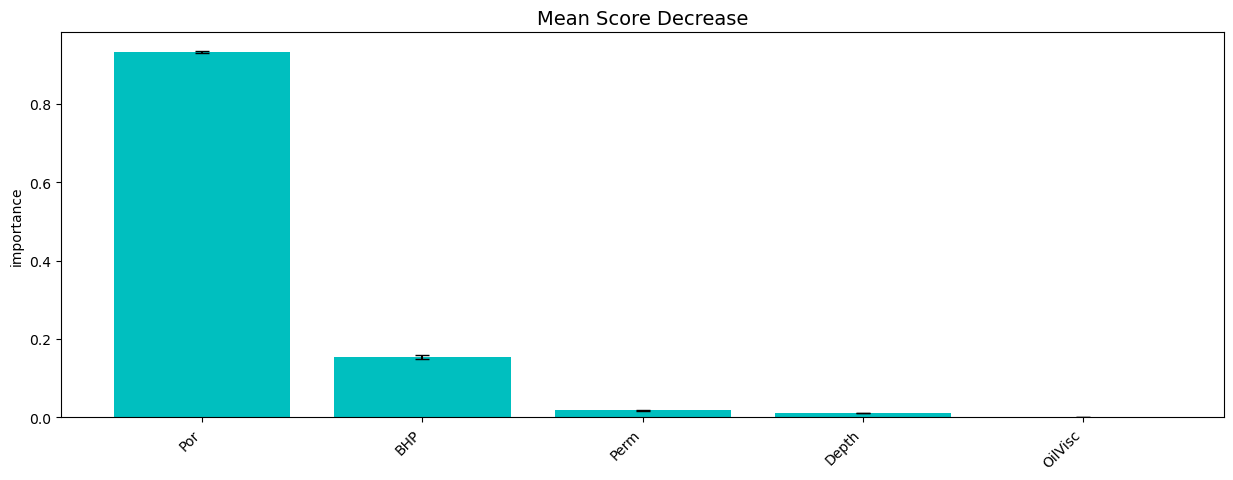

In [24]:
df_imp = mean_score_decrease(X_train, y_train, model_XGRF, plot=True, topk=10)

In [25]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['BHP', 'Depth', 'OilVisc', 'Perm', 'Por']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model_MAE = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring='neg_mean_absolute_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_MAE.fit(X_train, y_train)

print(model_MAE.best_params_)
print(model_MAE.score(X_train, y_train), model_MAE.best_score_, model_MAE.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.6918516030703091, 'algo__gamma': 1, 'algo__learning_rate': 0.1216411342539395, 'algo__max_depth': 3, 'algo__n_estimators': 185, 'algo__reg_alpha': 0.011502956321912733, 'algo__reg_lambda': 0.009461469059966103, 'algo__subsample': 0.7865052773762229}
-0.04443802334075931 -0.0711599162294775 -0.07383295033447254


In [27]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['BHP', 'Depth', 'OilVisc', 'Perm', 'Por']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model_MSE = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring='neg_mean_squared_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_MSE.fit(X_train, y_train)

print(model_MSE.best_params_)
print(model_MSE.score(X_train, y_train), model_MSE.best_score_, model_MSE.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.5261245937025092, 'algo__gamma': 1, 'algo__learning_rate': 0.08498604636076731, 'algo__max_depth': 5, 'algo__n_estimators': 122, 'algo__reg_alpha': 0.0015568103018717575, 'algo__reg_lambda': 6.2601238645330595, 'algo__subsample': 0.7433401936490238}
-0.013736695277748082 -0.044117356946950174 -0.024715680495945767


In [ ]:
save_model (model_XGRF, 'Predict_RF')

# Finishing

In [ ]:
RF_test = model_XGRF.predict(X_test)
RF_train = model_XGRF.predict(X_train)

In [ ]:
load_model ('model/Predict_RF')

In [ ]:
X_train.head()

In [ ]:
df.columns

In [ ]:
input_variable_test = df.drop(columns='RF')

In [ ]:
input_variable_test.head()

In [ ]:
RF_Predict_XGB=model_XGRF.predict(input_variable_test)
df.insert(6, column='RF_XGB', value=RF_Predict_XGB, allow_duplicates=False)

In [ ]:
df.head(21)

In [ ]:
df.index

In [ ]:
df.reset_index(inplace=True)
df

In [ ]:
def get_rmse (y_true, y_pred):
    return np.sqrt (np.mean((y_pred-y_true)**2.00))
def get_rel_l2_error(y_true, y_pred):
    return np.linalg.norm(y_true-y_pred, 2) / np.linalg.norm(y_true, 2)

In [ ]:
X1 = df.ID
y1 = df.RF
y2 = df.RF_XGB

In [ ]:
fig = plt.figure(figsize= (10, 5))
ax = plt.axes()

rmse_XG = get_rmse(df['RF'], df['RF_XGB']) 
l2_XG = get_rel_l2_error(df['RF'], df['RF_XGB']) * 100

ax.plot(X1, y1, 'k-', label = 'RF_CMG')
ax.plot(X1, y2, 'r--', label = f'RF_XGB: (RMSE = {rmse_XG: .2f}, Relative Error: {l2_XG: .2f}%)')

ax.legend()
plt.xlabel('Experiment')
plt.ylabel('RF')